# SVM with Smote Model for Twitter Sentiment Analysis

This model will use SVM with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

It will use SMOTE to synthesize some data to balance the classes.

It will use Lemmatization to reduce dimensionality

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import evaluation_functions
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import ast

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
DATA_FILE_PATH = 'C:\\Users\\Yostina\\Twitter\\'
TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [ ]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [ ]:
df.head()

In [ ]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [ ]:
data = df[['tokens', 'is_there_an_emotion_directed_at_a_brand_or_product']]

In [ ]:
data.head()

# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [2]:
X_train.shape

NameError: name 'X_train' is not defined

In [3]:
X_test.shape

NameError: name 'X_test' is not defined

# Encode Labels

In [4]:
le = LabelEncoder()

In [5]:
y_train_enc = le.fit_transform(y_train)

NameError: name 'y_train' is not defined

In [ ]:
y_test_enc = le.transform(y_test)

# Evaluate Adjustments to Minimum Document Frequency

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc]

In [ ]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [ ]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a SVM
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([('bow',CountVectorizer(min_df=min_df, 
                                                preprocessor=passthrough, 
                                                tokenizer=LemmaTokenizer())),
                         ('tfidf', TfidfTransformer()),
                         ('smote', SMOTE(random_state=RANDOM_STATE, 
                                         n_jobs=-1)),
                         ('classifier', SGDClassifier(loss='hinge', 
                                                      penalty='l2',
                                                      alpha=1e-3, 
                                                      random_state=RANDOM_STATE,
                                                      max_iter=5, 
                                                      tol=None))])
    
    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_train, 
                                                                 y_train_enc, 
                                                                 le.classes_, 
                                                                 'Training')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_test, 
                                                                 y_test_enc, 
                                                                 le.classes_,
                                                                 'Test')
    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
        
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy]),
                             recall_scores)
   
    return test_results
    

In [ ]:
metrics_summary = []

for min_df in range(1,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

In [18]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'train accuracy',
                                           'test accuracy',
                                          'neg recall',
                                          'neutral recall',
                                          'pos recall'])

metrics_summary_df

,min doc freq,train accuracy,test accuracy,neg recall,neutral recall,pos recall
0,1.0,0.688694,0.574096,0.596330,0.605238,0.513937
1,2.0,0.676149,0.570012,0.605505,0.611057,0.489547
2,3.0,0.665791,0.567095,0.587156,0.601358,0.501742
3,4.0,0.659664,0.558926,0.587156,0.599418,0.480836
4,5.0,0.651495,0.556009,0.577982,0.596508,0.479094
5,6.0,0.645806,0.558343,0.587156,0.607177,0.465157
6,7.0,0.640408,0.557760,0.596330,0.612027,0.452962
7,8.0,0.636324,0.561260,0.623853,0.612027,0.458188
8,9.0,0.633844,0.554259,0.623853,0.606208,0.447735
9,10.0,0.629468,0.554842,0.614679,0.600388,0.461672


/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 1

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.30      0.94      0.45       436
No emotion toward brand or product       0.84      0.70      0.77      4124
                  Positive emotion       0.70      0.61      0.65      2295

                          accuracy                           0.69      6855
                         macro avg       0.61      0.75      0.62      6855
                      weighted avg       0.76      0.69      0.71      6855



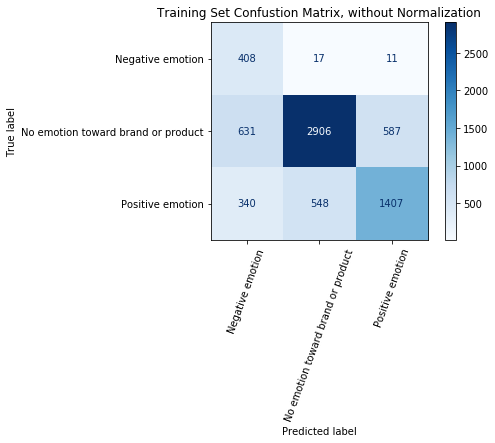

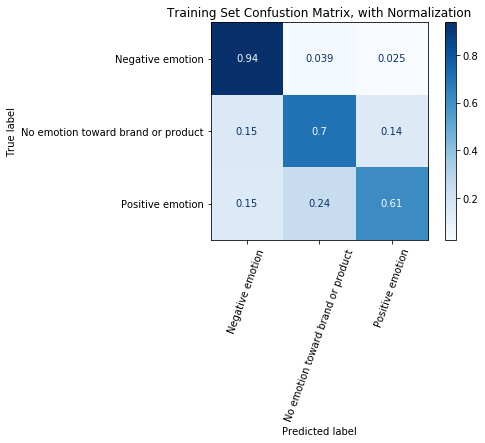

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.60      0.27       109
No emotion toward brand or product       0.78      0.61      0.68      1031
                  Positive emotion       0.56      0.51      0.53       574

                          accuracy                           0.57      1714
                         macro avg       0.50      0.57      0.49      1714
                      weighted avg       0.66      0.57      0.60      1714



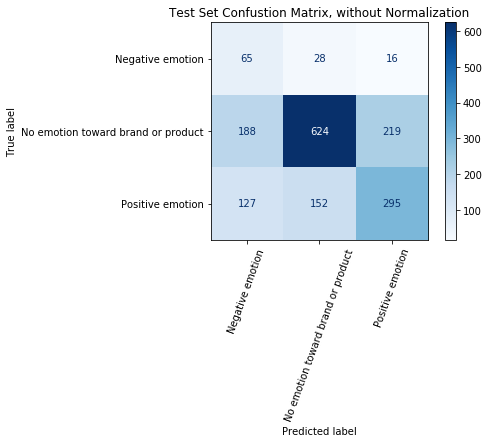

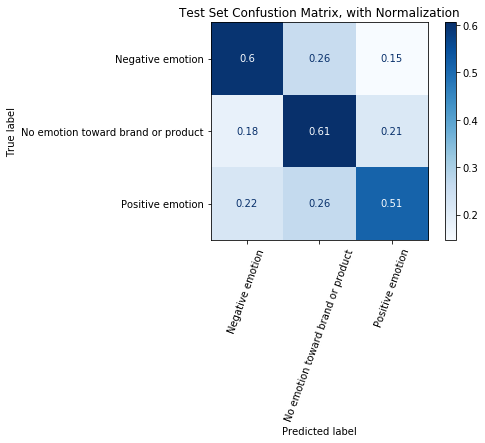

In [19]:
metrics = train_and_eval_model(min_df=1)

# Summary

The addition of lemmatization resulted in slightly worse performance compared to the SVM model with just SMOTE oversampling.  All the recall values went down by 0.01 to 0.02 and the accuracy went down by 2%.